<a href="https://colab.research.google.com/github/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/02-fully-connected-networks/03_better_neural_network_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Better neural networks training

If we make the input to the loss function a neural network, we can use this exact same approach to train a neural network. This creates a process called a training loop with three major components: 
* the training data (with correct answers), 
* the model and loss function, 
* the update via gradients

<img src='https://github.com/rahiakela/deep-learning-research-and-practice/blob/main/inside-deep-learing/02-fully-connected-networks/images/1.png?raw=1' width='600'/>

Our model needs parameters to adjust. Changing the parameters allows the network to alter its predictions to try to reduce the loss function.

Now we have all we need to abstractly describe learning as a function minimization problem.

##Setup

In [ ]:
from tqdm.autonotebook import tqdm

import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from sklearn.datasets import make_moons

import time

In [ ]:
!wget https://github.com/EdwardRaff/Inside-Deep-Learning/raw/main/idlmam.py

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import * 
from idlmam import *

In [4]:
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png', 'pdf')

def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)

torch.backends.cudnn.deterministic=True
set_seed(42)

In [5]:
def move_to(obj, device):
  """
  obj: the python object to move to a device, or to move its contents to a device
  device: the compute device to move objects to
  """
  if hasattr(obj, "to"):
      return obj.to(device)
  elif isinstance(obj, list):
      return [move_to(x, device) for x in obj]
  elif isinstance(obj, tuple):
      return tuple(move_to(list(obj), device))
  elif isinstance(obj, set):
      return set(move_to(list(obj), device))
  elif isinstance(obj, dict):
      to_ret = dict()
      for key, value in obj.items():
          to_ret[move_to(key, device)] = move_to(value, device)
      return to_ret
  else:
      return obj

##Defining dataset

Here we’ve created moons dataset.Since the
moons data is synthetic, we can easily create a new dataset for validation.

In [6]:
# Creates moons dataset
x_train, y_train = make_moons(n_samples=8000, noise=0.4)
x_test, y_test = make_moons(n_samples=200, noise=0.4)

train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.long))
test_dataset = TensorDataset(torch.tensor(x_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.long))

training_loader = DataLoader(train_dataset, shuffle=True)
testing_loader = DataLoader(test_dataset)

##The training loop

In [7]:
def train_model(model, optimizer, data_loader, loss_func, device="cpu", results=None, score_funcs=None, prefix="", desc=None):
  running_loss = []
  y_true = []
  y_pred = []
  start = time.time()

  # iterating through all the inputs (features) and labels (target)
  for inputs, labels in tqdm(data_loader, desc=desc, leave=False):
    # Move the batch of data to the device we are using
    inputs = move_to(inputs, device)
    labels = move_to(labels, device)

    # perform the prediction
    y_hat = model(inputs)

    # Compute loss
    loss = loss_func(y_hat, labels)

    if model.training:
      # compute the gradient
      loss.backward()
      # Now we just need to update all the parameters
      optimizer.step()
      optimizer.zero_grad()

    # Now we are just grabbing some information we would like to have
    running_loss.append(loss.item())

    # Finally, we need to store the labels and predictions
    if len(score_funcs) > 0 and isinstance(labels, torch.Tensor):
      # moving labels & predictions back to CPU for computing / storing predictions
      labels = labels.detach().cpu().numpy()
      y_hat = y_hat.detach().cpu().numpy()
      # add to predictions so far
      y_true.extend(labels.tolist())
      y_pred.extend(y_hat.tolist())
  
  # end training epoch
  end = time.time()

  y_pred = np.asarray(y_pred)
  # We have a classification problem, convert to labels
  if len(y_pred.shape) == 2 and y_pred.shape[1] > 1:
    y_pred = np.argmax(y_pred, axis=1)
  
  # Else, we assume we are working on a regression problem
  results[prefix + " loss"].append(np.mean(running_loss))
  for name, score_func in score_funcs.items():
    try:
      results[prefix + " " + name].append(score_func(y_true, y_pred))
    except:
      results[prefix + " " + name].append(float("NaN"))

  # return time spent on epoch
  return end - start

##A better model training function

In [8]:
def train_network(model, loss_func, train_loader, test_loader=None, score_funcs=None, epochs=50, device="cpu", checkpoint_file=None):

  tracking = ["epoch", "total time", "train loss"]

  if test_loader is not None:
    tracking.append("test loss")
  
  for eval_score in score_funcs:
    tracking.append("train " + eval_score)
    if test_loader is not None:
      tracking.append("test " + eval_score)

  # How long have we spent in the training loop?
  total_train_time = 0
  results = {}
  # Initialize every item with an empty list
  for item in tracking:
    results[item] = []

  # SGD is Stochastic Gradient Decent
  optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

  # Place the model on the correct compute resource (CPU or GPU)
  model.to(device)

  # iterating through all the data (batches) multiple times (epochs)
  for epoch in tqdm(range(epochs), desc="Epoch"):
    # Put the model in training mode
    model = model.train()

    # train the model
    total_train_time += train_model(model, optimizer, train_loader, loss_func, device, results, score_funcs, prefix="train", desc="Training")
    
    results["total time"].append(total_train_time)
    results["epoch"].append(epoch)

    if test_loader is not None:
      model = model.eval()
      with torch.no_grad():
        train_model(model, optimizer, test_loader, loss_func, device, results, score_funcs, prefix="test", desc="Testing")

  # lets us save the model, the optimizer state, and other information, all in one object
  if checkpoint_file is not None:
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "results": results
    }, checkpoint_file)

  # Finally, convert the results into a pandas DataFrame
  return pd.DataFrame.from_dict(results)

##Training model

We have everything we need to train our model.

In [ ]:
model = nn.Sequential(
    nn.Linear(2, 30),
    nn.Tanh(),
    nn.Linear(30, 30),
    nn.Tanh(),
    nn.Linear(30, 2)
)

loss_func = nn.CrossEntropyLoss()

results_pd = train_network(model, 
                          loss_func, 
                          training_loader,
                          epochs=5, test_loader=testing_loader,
                          checkpoint_file="model.pt",
                          score_funcs={"Acc": accuracy_score, "F1": f1_score})

In [10]:
results_pd.head()

,epoch,total time,train loss,test loss,train Acc,test Acc,train F1,test F1
0,0,5.186400,0.430262,0.394384,0.811625,0.830,0.810369,0.830000
1,1,16.934731,0.377710,0.392896,0.833375,0.835,0.832643,0.835821
2,2,27.501434,0.376355,0.394390,0.834375,0.835,0.834064,0.835821
3,3,32.775357,0.375273,0.393163,0.834875,0.835,0.834772,0.835821
4,4,38.042876,0.374356,0.391574,0.836750,0.835,0.836750,0.835821


In [11]:
results_pd.tail()

,epoch,total time,train loss,test loss,train Acc,test Acc,train F1,test F1
0,0,5.186400,0.430262,0.394384,0.811625,0.830,0.810369,0.830000
1,1,16.934731,0.377710,0.392896,0.833375,0.835,0.832643,0.835821
2,2,27.501434,0.376355,0.394390,0.834375,0.835,0.834064,0.835821
3,3,32.775357,0.375273,0.393163,0.834875,0.835,0.834772,0.835821
4,4,38.042876,0.374356,0.391574,0.836750,0.835,0.836750,0.835821


let’s see that we can load our checkpoint model.

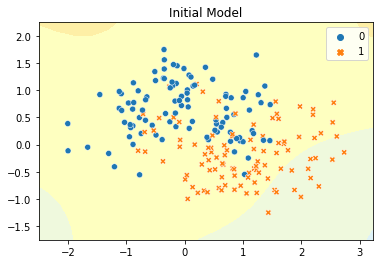

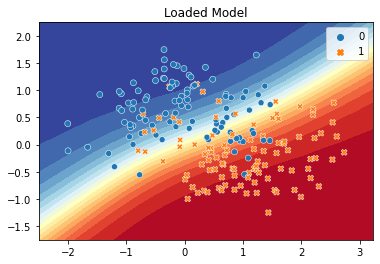

In [12]:
model_new = nn.Sequential(
    nn.Linear(2, 30),
    nn.Tanh(),
    nn.Linear(30, 30),
    nn.Tanh(),
    nn.Linear(30, 2)
)

visualize2DSoftmax(x_test, y_test, model_new)
plt.title("Initial Model")
plt.show()

# load the model
checkpoint_dict = torch.load("model.pt", map_location="cpu")
model_new.load_state_dict(checkpoint_dict["model_state_dict"])

visualize2DSoftmax(x_test, y_test, model_new)
plt.title("Loaded Model")
plt.show()

You can easily see that the initial model does not give very good predictions because its
weights are random values and untrained.

Let's quickly plot the training and validation
accuracy.

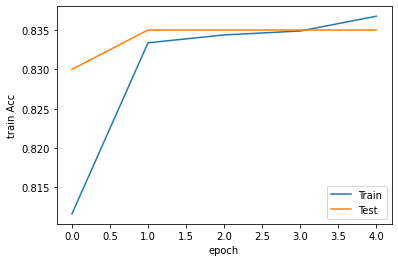

In [13]:
sns.lineplot(x="epoch", y="train Acc", data=results_pd, label="Train")
sns.lineplot(x="epoch", y="test Acc", data=results_pd, label="Test")

It’s now easy to see that by using more data, it took about two epochs for our model to
top out on the noisier training data.

let’s look
at the F1 score.

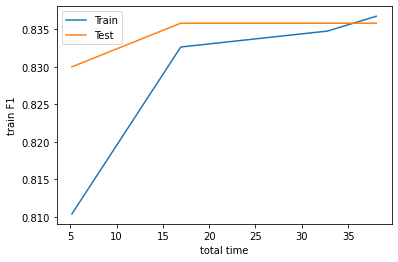

In [14]:
sns.lineplot(x="total time", y="train F1", data=results_pd, label="Train")
sns.lineplot(x="total time", y="test F1", data=results_pd, label="Test")

##Training in batches

If we push all $N$ data points through the model and compute the loss over the
entire dataset, $\sum_{i=1}^N l(f(x_i), y_i)$ we get the true gradient.

This can also make our
training more computationally efficient by processing all of the data at once instead of
one datum at a time.

So instead of passing in a vector with a shape of $(d)$ as the input
to a model $f(.)$, we pass in a matrix of shape $(N, d)$.

PyTorch modules are designed for
this situation by default; we just need a way to tell PyTorch to group our data into a
larger batch. It turns out the DataLoader has this functionality built in with the optional
`batch_size` argument.

In [15]:
training_loader = DataLoader(train_dataset, batch_size=len(train_dataset), shuffle=True)
testing_loader = DataLoader(test_dataset, batch_size=len(test_dataset))

In [ ]:
model_gd = nn.Sequential(
    nn.Linear(2, 30),
    nn.Tanh(),
    nn.Linear(30, 30),
    nn.Tanh(),
    nn.Linear(30, 2)
)

results_true_gd = train_network(model_gd, 
                                loss_func, 
                                training_loader,
                                epochs=5, test_loader=testing_loader,
                                checkpoint_file="model.pt",
                                score_funcs={"Acc": accuracy_score, "F1": f1_score})

Clearly, training on more data at
one time has allowed us to benefit from the parallelism available in a modern GPU. 

But if we plot the accuracy, we see that training the gradient descent (B = N) has produced a less accurate model:

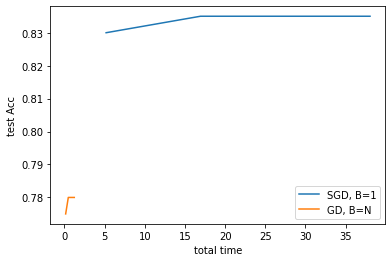

In [17]:
sns.lineplot(x="total time", y="test Acc", data=results_pd, label="SGD, B=1")
sns.lineplot(x="total time", y="test Acc", data=results_true_gd, label="GD, B=N")